In [1]:
from src.paper_to_equation.Gemini.GeminiPredict import GeminiPredict
import google.generativeai as genai
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import os

In [18]:
api_key = os.getenv("GEMINI_API_KEY")
filename = "Data/HTC_gemini6"
model = "tunedModels/mmltopython4-f3fuppiemnq9"
genai.configure(api_key=api_key)
gp = GeminiPredict(api_key, model)
gp.predict_from_txt("Data/HTC_mml.txt") 
gp.save_predictions(new_filename=filename)

API key loaded successfully!


Generating Predictions: 100%|██████████| 13/13 [00:08<00:00,  1.45row/s]


In [ ]:
class SystemOfEquations():
    def __init__(self, filepath):
        self.str_equations = []
        self.eq = []
        self.filepath = filepath
        self.symbol_lines = set() # Only keep one instance of each symbol line
        self.symbols = set() # Same for symbols
        self._extract_equations()
        for eq in self.str_equations:
            if not self.validate(eq):
                raise Exception("MathML to SymPy conversion error.") 
        

    def _extract_equations(self):
        """
        Store the equations in a list of strings
        """
        with open (f"{self.filepath}", "r") as file: 
            for line in file:
                self.str_equations.append(line)

    def get_equations(self):
        """
        Getter for the equation list
        """
        if not self.str_equations:
            self.extract_equations()

        return self.str_equations

    def validate(self, equation):
        """
        Check if the equation string is valid SymPy/Python code

        Args:
            equation (str): The equation string to validate

        Returns:
            True if the equation is valid
            False if the equation is invalid
        """
        try:
            eval(equation) # Execute the equation string as code
            return True
        except Exception as e:
            print(e)
            return False

    def parse_equation(self, equation):
        """
        Parse the equation string and store the symbols and equations

        Args:
            equation (str): The equation string to parse
        """
        for line in equation.split("\\n"): # Split equation string into lines (e.g. Symbol, Symbol, Eq)
            if "Symbol" in line:
                line = line.replace('"', "")
                self.symbol_lines.add(line) # Store line for file creation
                self.symbols.add(line.split(" = ")[0]) # Store symbol as a variable
            elif "Eq" in line:
                eq = line.split(" = ")[1]
                eq = eq.replace('"\n', "")
                self.eq.append(sympify(eq)) # Store the equation as a SymPy equation

    def solve(self, target):
        pass
    
    def solve_test(self, target):
        symbol_list = {"a", "b", "c"}
        const = {"c"}

        # Define symbols dynamically
        sd = {name: Symbol(name) for name in symbol_list if name not in const}

        # Substitute c = 4 directly in the equations
        c = 4
        # og_eq = [Eq(a, b + 5), Eq(b, c + 1)]
        equations = [Eq(sd["a"], sd["b"] + 5), Eq(sd["b"], c + 1)]
        # equations = [eq.subs({a: sd["a"], b: sd["b"]}) for eq in og_eq]

        # Solve for a
        result = solve(equations)
        print(result[sd[target]])
    
    def solve_test2(self, target):
        pass





def main():
    soe = SystemOfEquations("Data/HTC_gemini5_predictions.txt")
    for eq in soe.str_equations:
        soe.parse_equation(eq)
    print(soe.eq)
    


main()

In [ ]:
from collections import defaultdict, deque

class EquationGraph():
    def __init__(self, equations, equation_n):
        self.n = equation_n - 1
        self.equations = equations
        self.graph = defaultdict(set)
        self.var_equation = {}
        self._graph_init()

    def _graph_init(self):
        target_eq = self.equations[self.n]
        target = target_eq.lhs.free_symbols

        duplicates = []
        for i, eq in enumerate(self.equations):
            if eq.lhs.free_symbols == target:
                duplicates.append(i)

        result = [item for i, item in enumerate(self.equations) if i not in duplicates]
        self.equations = result
        self.equations.insert(0, target_eq)
        self.target = target

        for eq in self.equations:
            lhs = eq.lhs.free_symbols
            rhs = eq.rhs.free_symbols

            for var in lhs:
                self.graph[var].update(rhs)
                self.var_equation[var] = eq
    
    def BFS_for_vars(self):
        seen = set()
        queue = deque(self.target)

        while queue:
            var = queue.popleft()
            if var not in seen:
                seen.add(var)
                queue.extend(self.graph[var])
        
        return seen
    
    def get_system_of_equations(self):
        dependencies = self.BFS_for_vars()
        return [self.var_equation[var] for var in dependencies]





def test():
    # Constants
    # k_s (unit=(kW/mK))
    k_s = 0.14
    # k_t (unit=(H13))
    k_t = 0.0244
    # k_t (unit=(Cast iron))
    k_t = 0.044
    # k_t (unit=(P20))
    k_t = 0.0315
    # k_l (unit=(Lubricant))
    k_l = 0.024
    # R_s (unit=(m))
    R_s = 3.4e-07
    Rs = 3.4e-07
    # R_t (unit=(P20))
    R_t = 9.6e-07
    Rt = 9.6e-07
    # h_a (unit=(kW/m^(2)K))
    h_a = 0.8
    # sigma_U (unit=Unknown)
    sigma_U = 21.0
    σ_U = 21.0
    # alpha (unit=(−))
    alpha = 0.000201
    α = 0.000201
    # lambda_ (unit=(−))
    lambda_ = 6.05
    λ = 6.05
    # beta (unit=(−))
    beta = 0.00011
    β = 0.00011
    # gamma (unit=(m^(−1)))
    gamma = 200000.0
    γ = 200000.0
    # delta (unit=(−))
    delta = 1.5e-5
    δ = 1.5e-5

    # Variables
    h = Symbol("h")
    h_c = Symbol("h_c")
    K_st = Symbol("K_st")
    R = Symbol("R")
    N_P = Symbol("N_P")
    h_l = Symbol("h_l")
    K_stl = Symbol("K_stl")
    N_L = Symbol("N_L")

    P = 10
    h_g = 2
    exprs = [
        Eq(h, h_a + h_c + h_l),
        Eq(h_c, alpha * (K_st * N_P) / R),
        Eq(K_st, 2 / (k_s ** (-1) + k_t ** (-1))),
        Eq(R, np.sqrt(R_s ** 2 + R_t ** 2)),
        Eq(N_P, 1 - np.exp(- lambda_ * P / sigma_U)),
        Eq(h_l, beta * (K_stl * N_L) / R),
        Eq(K_stl, 3 / (k_s ** (-1) + k_t ** (-1) + k_l ** (-1))),
        Eq(N_L, 1 - np.exp(- gamma * delta)),
        Eq(h, h_c + h_g)
    ]

    k = 1
    p = 1
    H = 1
    θ = 1
    σ = 1
    K = 1
    C = 1
    A = 1
    B = 1
    k_f = 1
    k_w = 1
    h_f = 1

    exprs2 = [Eq(h, h_c + h_g), 
              Eq(h, 1.45*k*(p/H)**0.985*tan(θ)/σ), 
              Eq(h, 8000*λ*(K*p/(C*σ_U))**0.86), 
              Eq(h, A*(1 - exp(-B*P))), 
              Eq(h, 2*k_f*k_t*k_w*(1 - A)/(h_f*(-k_f*k_t - k_f*k_w + 2*k_t*k_w))), 
              Eq(h, h_a + h_c + h_l), 
              Eq(h_c, K_st*N_P*α/R), 
              Eq(K_st, 2/(1/k_t + 1/k_s)), 
              Eq(R, sqrt(Rs**2 + Rt**2)), 
              Eq(N_P, 1 - exp(-P*λ/σ_U)), 
              Eq(h_l, K_stl*N_L*β/R), 
              Eq(K_stl, 3/(1/k_t + 1/k_s + 1/k_l)), 
              Eq(N_L, 1 - exp(-γ*δ))]
    

    eg = EquationGraph(exprs2, 6)
    goodeqs = eg.get_system_of_equations()
    sol = solve(goodeqs)[0]
    sol2 = solve(eg.equations)[0]
    print(sol[h], sol2[h])
    # print(exprs)
    # print(goodeqs)
    

test()

In [ ]:
import random
import csv
from tqdm import tqdm

class Evaluator():
    def __init__(self, ref_filepath, pred_filepath):
        self.ref_filepath = ref_filepath
        self.pred_filepath = pred_filepath
        self.refs = []
        self.preds = []
        self._extract_references()
        self._extract_predictions()
        if len(self.refs) != len(self.preds):
            raise Exception(f"Reference and prediction lengths do not match: {len(self.refs)} refs vs {len(self.preds)} preds.")

    def _extract_references(self):
        """
        Store the equations in a list of strings
        """
        with open (f"{self.ref_filepath}", "r") as file: 
            reader = csv.reader(file)
            next(reader)
            for row in reader:
                self.refs.append(row[1])
    
    def _extract_predictions(self):
        """
        Store the equations in a list of strings
        """
        with open (f"{self.pred_filepath}", "r") as file: 
            for line in file:
                self.preds.append(line)

    def solve_ref(self, equation, seed=1):
        random.seed(seed)
        locals = {}
        exec(equation, globals(), locals)

        sub_dict = {}
        for symbol in locals["e"].rhs.free_symbols:
            sub_dict[symbol] = random.randint(10, 11)
        return locals["e"].subs(sub_dict).rhs.evalf()
    
    def solve_pred(self, equation, seed=1):
        for line in equation.split("\\n"):
            if "Eq" in line:
                eq = line.split(" = ")[1]
                eq = eq.replace('"\n', "")
        eq = sympify(eq)

        sub_dict = {}
        for symbol in eq.rhs.free_symbols:
            sub_dict[symbol] = random.randint(10, 11)
        return eq.subs(sub_dict).rhs.evalf()

    
    def metric_solve_rhs(self, seed=1):
        correct = 0
        total = len(self.refs)
        for ref, pred in tqdm(zip(self.refs, self.preds), total=len(self.refs), desc="Solving pairs"):
            attempts = 0
            while attempts < 3:
                print("trying")
                try:
                    # Solve and compare
                    if self.solve_ref(ref, seed + attempts) - self.solve_pred(pred, seed + attempts) < 1e-5:
                        print("here")
                        correct += 1
                        break  # Exit retry loop if successful
                except (ValueError, TypeError) as e:  # Handle specific exceptions
                    attempts += 1  # Increment attempts


        return f"{correct / total * 100}% of equations solved correctly." 

def test():
    ev = Evaluator("Data/gemini_test_4.csv", "Data/gemini_test_4_predictions.txt")
    equation = "Χ = Symbol('Χ')\nΟ = Symbol('Ο')\nK = Symbol('K')\nι = Symbol('ι')\ne = Eq(exp(Χ) + log(Ο), exp(K)*tan(ι))"
    sol = ev.solve(equation)
    print(sol)

def main():
    eval = Evaluator("Data/gemini_test_4.csv", "Data/gemini_test_4_predictions.txt")
    print(eval.metric_solve_rhs())

if __name__ == "__main__":
    main()

In [ ]:
from sympy import *
import numpy as np

mu = Symbol("mu")
mu_l = Symbol("mu_l")
mu_d = Symbol("mu_d")
beta = Symbol("beta")
Q_l = 7.8
Q_d = 8.8
mu_l0 = 1.23
mu_d0 = 9.65
lambda_1 = 20
lambda_2 = 1.1
h = Symbol("h")
c = 0.012
P = 5
v = 50
eta = Symbol("eta")
eta_0 = 0.12
Q_eta = 11.93
T = 300
R = 8.314
k_p = 2.05
k_v = 2.98
k_eta = 5.3
t = Symbol("t")

exprs = [Eq(mu, (1 - beta) * mu_l + beta * mu_d),
         Eq(mu_l, mu_l0 * exp(-Q_l/(R * T))),
         Eq(mu_d, mu_d0 * exp(-Q_d/(R * T))),
         Eq(beta, exp(-(lambda_1 * h) ** lambda_2)),
         Eq(Derivative(h, t), -h * (c * (P ** k_p) * (v ** k_v)) / (eta ** k_eta)),
         Eq(eta, eta_0 * exp(-Q_eta/(R * T)))]

t_vals = np.linspace(0, 10, 100)

for val in t_vals:
    t = val
    sol = dsolve(exprs)[0]
    print(sol[mu])

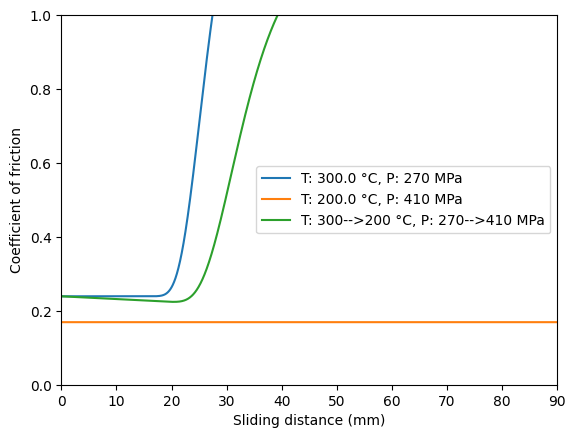

In [2]:
def friction_model():
    x=[2, 1.1, 1.2, 2.05, 2.98, 5.3, 0.12, 1.435]
    
    lambda1=x[0]*10
    lambda2=x[1]
    c=x[2]/100
    k1=x[3]
    k2=x[4]
    k3=x[5]
    ita0=x[6]
    A=x[7]*1000 # = Q_eta/R
    ul0 = 1.23
    ud0 = 9.65
    Al = 7.8E3 / 8.314
    Ad = 8.8E3 / 8.314
    
    Tmin= 200 + 273; # Kelvin
    Tmax= 300 + 273; # Kelvin

    P200 = 0.41
    P300 = 0.27

    v = 50 # mm/s
    
    T_array = np.linspace(Tmax, Tmin, 5)
    P_array = np.linspace(P300, P200, 5)


    cof_store = []   
    labels = []
    
    # 5 constant temperatures and pressures
    for i in range(5):
        T = T_array[i] # Kelvin
        P = P_array[i] # GPa

        ita = ita0 * np.exp(A / T)
        ul = ul0 * np.exp(-Al / T)
        ud = ud0 * np.exp(-Ad / T)        

        t_step=0.0005
        max_sliding_distance = 90 # mm
        timesteps = int(max_sliding_distance/v/t_step) # 3600
        t=np.zeros(timesteps)
        slidingdistance=np.linspace(0,90,timesteps) # 3600 distance points
        ht_dot=np.zeros(timesteps)
        ht=np.zeros(timesteps+1)
        beta=np.zeros(timesteps)
        u=np.zeros(timesteps)
        
        # initial lubricant thickness: um
        ht[0]=25
        
        for j in range(timesteps):
            t[j]=j*t_step
            ht_dot[j]=-ht[j]*(c*(P**k1)*(v**k2)/(ita**k3))
            ht[j+1]=ht[j]+ht_dot[j]*t_step
            beta[j]=np.exp(-(lambda1*ht[j])**lambda2)
            u[j]=(1-beta[j])*ul+beta[j]*ud
        
        cof_store.append(u)
        labels.append(f"T: {T-273} °C, P: {P*1000:.0f} MPa")
    
    # varying temperature/pressure
    T_array = np.linspace(Tmax, Tmin, timesteps)
    P_array = np.linspace(P300, P200, timesteps)

    t_step=0.0005
    max_sliding_distance = 90 # mm
    timesteps = int(max_sliding_distance/v/t_step) # 3600
    t=np.zeros(timesteps)
    slidingdistance=np.linspace(0,90,timesteps) # 3600 distance points
    ht_dot=np.zeros(timesteps)
    ht=np.zeros(timesteps+1)
    beta=np.zeros(timesteps)
    u=np.zeros(timesteps)

    # initial lubricant thickness: um
    ht[0]=25

    for j in range(timesteps):
        T = T_array[j]
        P = P_array[j]
        ita = ita0 * np.exp(A / T)
        ul = ul0 * np.exp(-Al / T)
        ud = ud0 * np.exp(-Ad / T)  

        t[j]=j*t_step
        ht_dot[j]=-ht[j]*(c*(P**k1)*(v**k2)/(ita**k3))
        ht[j+1]=ht[j]+ht_dot[j]*t_step
        beta[j]=np.exp(-(lambda1*ht[j])**lambda2)
        u[j]=(1-beta[j])*ul+beta[j]*ud

    cof_store.append(u)
    labels.append(f"T: 300-->200 °C, P: 270-->410 MPa")

    # plot the results
    return cof_store, labels, slidingdistance

def plot_friction_model(cof_store, labels, slidingdistance):
    fig, ax = plt.subplots()
    for i in range(len(cof_store)):
        if i not in [1,2,3]:
            ax.plot(slidingdistance, cof_store[i], label=labels[i])
    ax.set_xlim(0, 90)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Sliding distance (mm)")
    ax.set_ylabel("Coefficient of friction")
    ax.legend()
    
    
        
        

cof_store, labels, slidingdistance = friction_model()
plot_friction_model(cof_store, labels, slidingdistance)

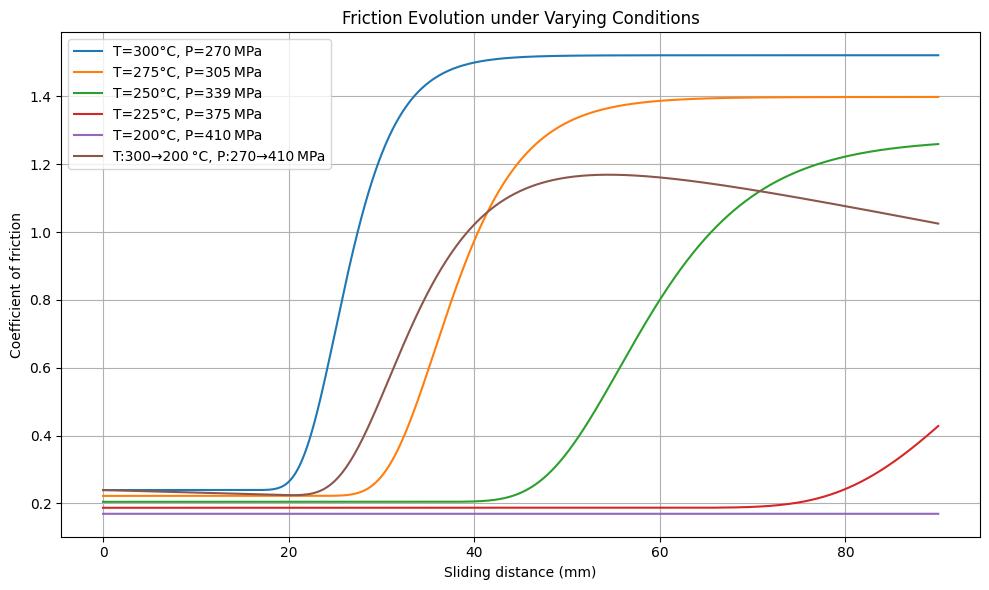

In [3]:
def run_simulation(T_array, P_array, v, ul0, ud0, Al, Ad, A, ita0, params, initial_ht=25, max_distance=90, t_step=0.0005):
    """
    Run the mixed-lubrication friction model simulation.
    
    Args:
        T_array (np.ndarray): Temperatures (K) for each timestep.
        P_array (np.ndarray): Pressures (GPa) for each timestep.
        v (float): Sliding speed (mm/s).
        ul0, ud0, Al, Ad (float): Arrhenius parameters for mu_l and mu_d.
        A, ita0 (float): Arrhenius parameters for viscosity.
        params (tuple): (lambda1, lambda2, c, k1, k2, k3).
        initial_ht (float): Initial film thickness (µm).
        max_distance (float): Total sliding distance (mm).
        t_step (float): Time step (s).
    
    Returns:
        u (np.ndarray): Coefficient of friction vs. timestep.
    """
    lambda1, lambda2, c, k1, k2, k3 = params
    timesteps = int(max_distance / v / t_step)
    t = np.zeros(timesteps)
    ht = np.zeros(timesteps + 1)
    ht_dot = np.zeros(timesteps)
    beta = np.zeros(timesteps)
    u = np.zeros(timesteps)
    
    ht[0] = initial_ht
    
    for j in range(timesteps):
        T = T_array[j]
        P = P_array[j]
        ita = ita0 * np.exp(A / T)
        ul = ul0 * np.exp(-Al / T)
        ud = ud0 * np.exp(-Ad / T)
        
        t[j] = j * t_step
        ht_dot[j] = -ht[j] * (c * P**k1 * v**k2 / ita**k3)
        ht[j+1] = ht[j] + ht_dot[j] * t_step
        beta[j] = np.exp(-(lambda1 * ht[j])**lambda2)
        u[j] = (1 - beta[j]) * ul + beta[j] * ud
    
    return u

def friction_model():
    """
    Simulate COF under five constant T/P conditions and one T/P ramp case.
    Returns:
        cof_list: List of COF arrays.
        labels: Corresponding legend labels.
        slidingdistance: Shared sliding distance array.
    """
    # Model constants
    x = [2, 1.1, 1.2, 2.05, 2.98, 5.3, 0.12, 1.435]
    lambda1 = x[0] * 10
    lambda2 = x[1]
    c = x[2] / 100
    k1, k2, k3 = x[3], x[4], x[5]
    ita0 = x[6]
    A = x[7] * 1000  # Q_eta / R
    
    ul0, ud0 = 1.23, 9.65
    Al = 7.8e3 / 8.314
    Ad = 8.8e3 / 8.314
    
    Tmin, Tmax = 200 + 273, 300 + 273  # K
    P200, P300 = 0.41, 0.27             # GPa
    v = 50                             # mm/s
    
    # Prepare arrays
    timesteps = int(90 / v / 0.0005)
    slidingdistance = np.linspace(0, 90, timesteps)
    
    params = (lambda1, lambda2, c, k1, k2, k3)
    cof_list, labels = [], []
    
    # Constant T/P runs
    T_const = np.linspace(Tmax, Tmin, 5)
    P_const = np.linspace(P300, P200, 5)
    for T, P in zip(T_const, P_const):
        T_array = np.full(timesteps, T)
        P_array = np.full(timesteps, P)
        u = run_simulation(T_array, P_array, v, ul0, ud0, Al, Ad, A, ita0, params)
        cof_list.append(u)
        labels.append(f"T={T-273:.0f}°C, P={int(P*1000)} MPa")
    
    # Ramp T/P case
    T_ramp = np.linspace(Tmax, Tmin, timesteps)
    P_ramp = np.linspace(P300, P200, timesteps)
    u_ramp = run_simulation(T_ramp, P_ramp, v, ul0, ud0, Al, Ad, A, ita0, params)
    cof_list.append(u_ramp)
    labels.append("T:300→200 °C, P:270→410 MPa")
    
    return cof_list, labels, slidingdistance

def plot_results(slidingdistance, cof_list, labels):
    """
    Plot COF vs. sliding distance for multiple cases.
    """
    plt.figure(figsize=(10, 6))
    for u, label in zip(cof_list, labels):
        plt.plot(slidingdistance, u, label=label)
    plt.xlabel("Sliding distance (mm)")
    plt.ylabel("Coefficient of friction")
    plt.title("Friction Evolution under Varying Conditions")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    cof_list, labels, slidingdistance = friction_model()
    plot_results(slidingdistance, cof_list, labels)



<lambdifygenerated-1>:2: RuntimeWarning: divide by zero encountered in divide
  return ud0*exp(-Ad/t)*exp(-(h0*lambda1*exp(-P*c*t*v/ita))**lambda2) + ul0*(1 - exp(-(h0*lambda1*exp(-P*c*t*v/ita))**lambda2))*exp(-Al/t)


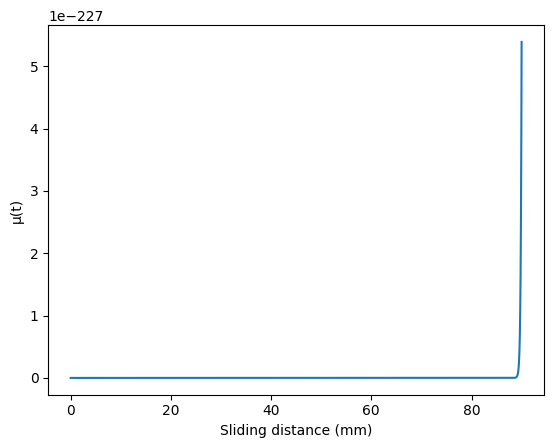

In [4]:
import sympy as sp

# 1) Declare symbols and function
t = sp.symbols('t', real=True, positive=True)
h = sp.Function('h')

# parameters
c, P, v, ita = sp.symbols('c P v ita', positive=True)
lambda1, lambda2 = sp.symbols('lambda1 lambda2', positive=True)
ul0, ud0 = sp.symbols('ul0 ud0', positive=True)
Al, Ad   = sp.symbols('Al Ad', positive=True)

# 2) ODE: dh/dt = -h * c * P^k1 * v^k2 / ita^k3
ode = sp.Eq(sp.diff(h(t),t), -h(t) * c*P**1 * v**1 / ita**1)  
# (lift exponents k1,k2,k3 for clarity in this example)

# 3) Solve with initial condition h(0)=h0
h0 = sp.symbols('h0', positive=True)
ics = {h(0): h0}
sol = sp.dsolve(ode, ics=ics)
h_t = sp.simplify(sol.rhs)
# sol.rhs will be h0*exp(-c*P*v/ita * t)

# 4) Build β(t) = exp(−(λ1·h(t))^λ2)  and μ(t)
beta_t = sp.exp( - (lambda1*h_t)**lambda2 )
mu_t   = (1-beta_t)*ul0*sp.exp(-Al/t) + beta_t*ud0*sp.exp(-Ad/t)

# 5) Lambdify into a fast numpy function
f_mu = sp.lambdify((t, h0, c, P, v, ita, lambda1, lambda2, ul0, ud0, Al, Ad),
                   mu_t, 'numpy')

# 6) Numeric example (300°C, P=0.27 GPa, etc.)
h0_val, c_val, P_val, v_val, ita_val = 25, 0.012, 0.27, 50, 0.12*np.exp(1435/573)
lam1, lam2 = 20, 1.1
ul0_val, ud0_val = 1.23, 9.65
Al_val, Ad_val   = 7.8e3/8.314, 8.8e3/8.314

# time vector and μ(t)
times = np.linspace(0, 90/v_val, 3600)   # 90 mm at 50 mm/s = 1.8 s
mus   = f_mu(times, h0_val, c_val, P_val, v_val, ita_val,
             lam1, lam2, ul0_val, ud0_val, Al_val, Ad_val)

plt.plot(times*v_val, mus)  # plot vs sliding distance
plt.xlabel("Sliding distance (mm)")
plt.ylabel("μ(t)")
plt.show()
